# Post-process: Reclassify Irrigated Croplands

## Description
Once we have generated land cover map, we can impliment customised post-processing to improve the map. In this example, we find that most of the irrigated croplands pixels were not identified by the classifier. Therefore, a tailored process is applied to identify irrigated croplands based on phenology and other set rules.

It is assumed that the irrigated crops are likely to have higher mean NDVI than non-irrigated crops over growing season. Therefore, the cropland class is clustered using a K-means approach with 2 clusters, and the cluster with higher mean NDVI was retained. A set of additional rules are then applied to identify irrigated cropland pixels using calculated or external layers:

* NDVI small integral over growing season;
* Slope derived from SRTM DEM layer;
* Hydrologically adjusted elevation;
* Pixel gourp size of identified irrigated croplands;

To start running the analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load Packages

In [1]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from rasterio.enums import Resampling
from odc.io.cgroups import get_cpu_quota
from odc.algo import xr_geomedian
from datacube.utils.cog import write_cog
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.temporal import xr_phenology
from sklearn.cluster import KMeans
# from skimage.measure import label,regionprops
from odc.algo import xr_reproject
import time
# import matplotlib.pyplot as plt
# from deafrica_tools.dask import create_local_dask_cluster
from sklearn.impute import SimpleImputer

## Analysis Parameters
In previous notebook, we only produced land cover prediction maps for a few selected small areas for demonstration purpose. To make sure the cropland pixel samples used for clustering are statistically large enough and representive of the two clusters, i.e. irrigated and non-irrigated croplands, we have prepared the land cover prediction map for the entire country.

* `classification2021_raster`: The path and name of the land cover prediction GeoTIFF for the entire country.
* `hand_raster`: Hydrologically adjusted elevations, i.e. height above the nearest drainage (hand).
* `dict_map`: A dictionary map of pixel value corresponding to each class name, including the irrigated cropland class.
* `testing_locations`: A dictionary with values containing latitude and longitude points, and keys representing a unique ID to identify the locations. The `lat` and `lon` points define the center of the satellite images we will load for running small test classifications.
* `buffer`: The size, in decimal degrees, to load around the central latitude and longitude points in `locations`.
* `output_crs`: Coordinate spatial reference for output rasters.

In [2]:
classification2021_raster='Results/Land_cover_prediction_balanced_newest_DEAfrica_2021_mosaic.tif'
hand_raster='Data/hand_Lesotho.tif'
dict_map={'Trees':1,'Grassland/shrubland':6,'Cropland':10,'Vegetated Wetland':11,
          'Open Water':12,'Settlements':13,'Irrigated Cropland':14} # class value dictionary
testing_locations = {
    '1': (-29.2506, 28.4537),
    '2': (-29.7080, 27.3721),
    '3': (-30.4453, 27.7948),
}
buffer = 0.01
output_crs='epsg:32735' # WGS84/UTM Zone 35S

## Load Raster Layers

In [3]:
# import land cover map of 2021
landcover2021=rioxarray.open_rasterio(classification2021_raster).astype(np.uint8).squeeze()

## Calculate Small NDVI Integral Layer
The NDVI integral is calculated for the period of growing season, which will be identified from time-series NDVI.
### Calculate NDVI time series
To calculate small NDVI integral over growing season, we first query Sentinel-2 data from ODC and calculate NDVI time series. In this example we choose the first testing location for processing as demonstration.  

Similar to the previous notebooks `1_Extract_training_data.ipynb` and `3_Land_Cover_Classification.ipynb`, we define a feature function to extract feature layers. However, here we only need measurements red and NIR bands to calculate NDVI, and will drop the two bands once NDVI is calculated. 

In [9]:
# choose the first testing location for query
testing_location=testing_locations['2']

# define a query: only two measurements are needed
query = {
    'x': (testing_location[1]-buffer, testing_location[1]+buffer),
    'y': (testing_location[0]+buffer, testing_location[0]-buffer),
    'time': ('2021-01', '2021-12'),
    'measurements': ['red','nir_1'],
    'resolution': (-10, 10),
    'output_crs':output_crs,
#         'dask_chunks' : {'x':1550, 'y':1550}
}
# define feature function
def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='integrated_NDVI')
    ds_multitime = load_ard(dc=dc,
              products=['s2_l2a'],
              group_by='solar_day',
              verbose=False,
              **query)
    ds_multitime = calculate_indices(ds_multitime,
                       index=['NDVI'],
                       drop=True, # note here keeps only NDVI bands
                       satellite_mission='s2')
    return ds_multitime

# calculate features
ds_NDVI=feature_layers(query)

Dropping bands ['red', 'nir_1']


### Calculate Phenology Statistics
We now calculte phenology statisticss from NDVI time series using the `xr_phenology` function, which can calculate a number of land-surface phenology statistics on a per-pixel basis that together describe the characteristics of a plant’s lifecycle. We define a list of phenology statistics `pheno_stats` which includes:
* `SOS`: DOY of start of season.
* `EOS`: DOY of end of season.
* `LOS`: Length of season (DOY).
* `Trough`: Minimum value of season.
where DOY = day-of-year (Jan 1st = 0, Dec 31st = 365). For more information on `xr_phenology` function and other phenology statistics it can calculate, see [the function description](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/gen/deafrica_tools.temporal.xr_phenology.html?highlight=xr_phenology#deafrica_tools.temporal.xr_phenology)

In [10]:
# define phenology statistics to be calculated
pheno_stats = ['SOS','EOS','LOS','Trough']

# calculate phenology stats using multi-temporal NDVI
stats=xr_phenology(ds_NDVI['NDVI'], method_sos='first', method_eos='last',stats=pheno_stats,verbose=False)

### Calculate Small Integration

In [25]:
# set non-growing season values as 0 so that they won't be included in integral calculation
ds_growing_season=xr.where((ds_NDVI['time.dayofyear']>=stats['SOS'])&(ds_NDVI['time.dayofyear']<=stats['EOS']),
        ds_NDVI,0)

# calculate integral over growing season
integrated_ndvi=ds_growing_season.assign_coords(time=ds_NDVI['time.dayofyear'].values/365.0).integrate(coord='time')

# normalise integral
integrated_ndvi['NDVI']=integrated_ndvi['NDVI']*365.0/stats['LOS'] 

# calculate small integral
small_integrated_ndvi=integrated_ndvi['NDVI']-stats['Trough']


In [26]:
ds_growing_season

<xarray.Dataset>
Dimensions:      (time: 73, y: 223, x: 195)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-01T08:18:23 ... 2021-12-27T08:...
    spatial_ref  int32 32735
  * y            (y) float64 6.715e+06 6.715e+06 ... 6.712e+06 6.712e+06
  * x            (x) float64 5.35e+05 5.35e+05 5.35e+05 ... 5.37e+05 5.37e+05
Data variables:
    NDVI         (time, y, x) float32 nan 0.0 0.0 nan 0.0 ... 0.0 0.0 0.0 0.0

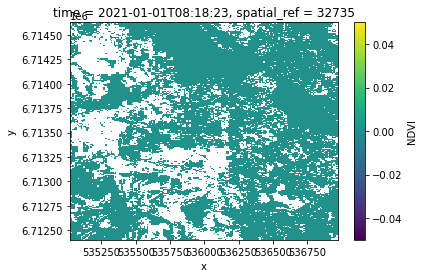

In [31]:
ds_growing_season.isel(time=0)['NDVI'].plot()

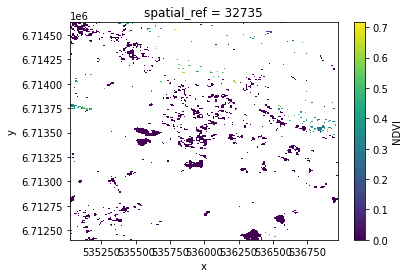

In [32]:
integrated_ndvi['NDVI'].plot(cmap='viridis')

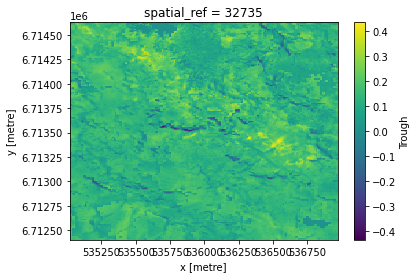

In [14]:
stats['Trough'].plot(cmap='viridis')

## Clustering Cropland Pixels
We first cluster cropland pixels into 2 clusters using a K-means approach, and identify the cluster with higher mean NDVI. The first step is to query the data cube and calculate bi-monthly geomedian of the NDVI.

### Calcualte bi-monthly geomedian

In [ ]:
ds_geomedian=ds_multitime.resample(time='2MS').map(xr_geomedian)
ds_geobox=ds_geomedian.geobox
print('geobox for integrated NDVI dataset: ',ds_geobox)
n_time=ds_geomedian.dims['time']
list_measurements=list(ds_geomedian.keys())
list_stack_measures=[]
for j in range(len(list_measurements)):
    for k in range(n_time):
        variable_name=list_measurements[j]+'_'+str(k)
        measure_single=ds_geomedian[list_measurements[j]].isel(time=k).rename(variable_name)
        list_stack_measures.append(measure_single)
ds_stacked=xr.merge(list_stack_measures,compat='override')

### K-means clustering
We can then fit a kmeans clusterer with two clusters to the data. Here we used a simple imputer which fills nodata with the mean value of valid pixels to interpolate pixels masked by cloud/cloud shadow.

In [ ]:
np_all_data=ds_stacked.to_dataframe()[ds_stacked.keys()].to_numpy()
#     print('kmeans input dimension: ',np_all_data.shape)
#     indices_nan=np.argwhere(np.isnan(np_all_data).any(axis=1)) # find rows with nan
#     print('number of pixels with nan: ',len(indices_nan))
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#     np_all_data[np.isnan(np_all_data)]=fill_nan_value # fill nan so that kmeans can be used
np_all_data=imp_mean.fit_transform(np_all_data) # fill nodata using simple imputer
# fit a kmeans clusterer of 2 clusters
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(np_all_data.astype('float32'))
print('kmeans centre:\n',kmeans_model.cluster_centers_)

Assuming that irrigated croplands have larger overal NDVI than non-irrigated, we can identify the cluster corresponding to irrigated cropland pixels.

In [ ]:
# find cluster with larger mean NDVI
cluster_irrigated=0
if np.sum(kmeans_model.cluster_centers_[0,:])>np.sum(kmeans_model.cluster_centers_[1,:]):
    cluster_irrigated=0
else:
    cluster_irrigated=1
print('cluster corresponding to irrigated croplands: ',cluster_irrigated)
labels=kmeans_model.predict(np_all_data)
labels=np.reshape(labels,(ds_stacked.dims['y'],ds_stacked.dims['x'])) # reshape cluster results to 2D array

## Load External Layers


In [ ]:
# load dem slope
dc = datacube.Datacube(app='slope_layer')
query_dem= {
    'x': (x_min,x_max),
    'y': (y_max,y_min),
    'resolution':(-10, 10),
    'crs':crs,
    'output_crs': crs,
    'measurements':['slope']
}
dem_slope = dc.load(product="dem_srtm_deriv", **query_dem).squeeze()
np_dem_slope=dem_slope['slope'].to_numpy()

# import hand layer
hand=xr.open_dataset(hand_raster,engine="rasterio").squeeze()
# load hand layer
hand=xr_reproject(hand, ds_geobox, resampling="average")
np_hand=hand.to_array().squeeze().to_numpy()

## Reclassify croplands using clustering and external layers
In addition, the identified areas were 
* NDVI small integral over growing season higher than 0.5;
* Slope lower than 10 degrees;
* Height Above Nearest Drainage lower than 45 metres;
* Pixel group larger than 100 pixels.
Here we apply a threshold to the hand layer, as irrigation can and most likely occur towards bottom of drainage.

In [ ]:
# apply rules to reclassify irrigated/non-irrigated using clustering and external layers
landcover2021_tile=xr_reproject(landcover2021.to_dataset(name='band_data'), ds_geobox, resampling="nearest") # clip to tile boundary
np_landcover2021=landcover2021_tile.to_array().squeeze().to_numpy()
np_landcover2021_post=np_landcover2021.copy()

# convert to numpy
np_integrated_ndvi=integrated_ndvi['NDVI'].to_numpy()

# generate initial irrigated cropland mask 
irrigated_mask=(labels==cluster_irrigated)&(np_integrated_ndvi>=0.5)&(np_dem_slope<=10)&(np_hand<=45)&(np_landcover2021==dict_map['Cropland'])
np_landcover2021_post[irrigated_mask]=dict_map['Irrigated Cropland'] # do not limit irriggated cropland sizes

## Save as geotiff

In [ ]:
# convert back result back to DataArray
landcover2021_tile_post=xr.DataArray(data=np_landcover2021_post,
                                     dims=['y','x'],
                                     coords={'y':landcover2021_tile.y.to_numpy(),
                                             'x':landcover2021_tile.x.to_numpy()})
landcover2021_tile_post.rio.write_crs(crs, inplace=True)
# export as geotiff
write_cog(landcover2021_tile_post, 'Results/Land_cover2021_add_irrigated_tile_'+str(i)+'.tif', overwrite=True)

In [ ]:
crs='epsg:32735' # WGS84/UTM Zone 35S
class_name = 'LC_Class_I' # class label in integer format
fill_nan_value=-999 # value to replace nans in query results


# file paths and attributes
lesotho_shp='Data/Rwanda_Boundary.shp' # Rwanda boundary shapefile
lesotho_tiles_shp='Data/Rwanda_tiles_epsg32736_smaller.shp' # Rwanda tiles shapefile
classification2021_raster='Results/Land_cover_prediction_Rwanda_balanced_2021_mosaic.tif' # land cover map of 2021


# import Lesotho boundaries and get bounding box
lesotho_polygon=gpd.read_file(lesotho_shp)
[x_min,y_min,x_max,y_max]=lesotho_polygon.total_bounds
print('Lethoso bbox: ',x_min,y_min,x_max,y_max)
lesotho_tiles=gpd.read_file(lesotho_tiles_shp).to_crs(crs) # get bounding boxes of tiles covering Lesotho
tile_bboxes=lesotho_tiles.bounds


In [4]:

for i in range(35,len(tile_bboxes)):
# for i in range(1):
    x_min,y_min,x_max,y_max=tile_bboxes.iloc[i]
    print('Processing tile ',i,'with bbox of ',x_min,y_min,x_max,y_max)
    
    # calculate integrated NDVI

    print("%s seconds spent on data query for one tile" % (time.time() - start_time))
    ds_multitime=ds_multitime.interpolate_na(dim='time',method='linear',use_coordinate=True) # fill nodata using linear interpolation
#     ds_multitime=ds_multitime.where((ds_multitime['NDVI']>-1)|(ds_multitime['NDVI'].isnull()),-1)
#     ds_multitime=ds_multitime.where((ds_multitime['NDVI']<1)|(ds_multitime['NDVI'].isnull()),1) # force NDVI values to be between -1 and 1
#     print('Number of nans after conditional operation: ',np.sum(ds_multitime['NDVI'].isnull().to_numpy()))

#     ds_multitime['time']=ds_multitime['time.dayofyear'] # convert datetime to day of year

#     fig, ax = plt.subplots(nrows=1,
#                        ncols=2,
#                        figsize=(18, 8),
#                        sharex=True,
#                        sharey=True)
#     integrated_ndvi['NDVI'].plot(ax=ax[0])
#     ax[0].set_title('integrated NDVI')

#     integrated_ndvi['NDVI'].plot(ax=ax[1])
#     ax[1].set_title('small integrated NDVI')
    
    del integrated_ndvi
    
    # calculate geomedians within each two-month interval
    
    del ds_multitime
#     print('multi-temporal geomedian dataset: \n',ds_geomedian)

    # convert multi-temporal S2 dataset to multiband dataset so that clusterer can be applied

    print('stacked geomedian dataset: \n',ds_stacked)
    del ds_geomedian
    # kmeans clustering for all pixels


    del np_all_data
#     labels[indices_nan]=cluster_irrigated+1 # assign those pixels with non-irrigated cluster

    del ds_stacked


#     # only keeping mask regions with number of pixels >= 100 pixels
#     irrigated_mask_filtered=np.zeros_like(irrigated_mask)
#     irrigated_counts=np.zeros_like(irrigated_mask,dtype='uint32')
#     label_image=label(irrigated_mask)
#     for region_prop in regionprops(label_image):
#         irrigated_counts[label_image==region_prop.label]=region_prop.area
#     irrigated_mask_filtered[irrigated_counts>=100]=1
#     np_landcover2021_post[irrigated_mask_filtered]=dict_map['Irrigated Cropland']

    

#     write_cog(landcover2021_tile_post, 'Results/Land_cover2021_postproc_step1_tile_'+str(i)+'.tif', overwrite=True)

Processing tile  35 with bbox of  886712.6342681092 9793853.29223998 916840.9619001417 9823981.62146932
Dropping bands ['red', 'nir_1']
55.98626112937927 seconds spent on data query for one tile
geobox for integrated NDVI dataset:  GeoBox(Geometry({'type': 'Polygon', 'coordinates': (((30.474451413683695, -1.5894683687761053), (30.4749459716754, -1.8616472568982003), (30.74531719796539, -1.861089728766236), (30.74478437189917, -1.5889923966481858), (30.474451413683695, -1.5894683687761053)),)}, CRS('EPSG:4326')))
stacked geomedian dataset: 
 <xarray.Dataset>
Dimensions:  (y: 3014, x: 3013)
Coordinates:
    time     datetime64[ns] 2021-01-01
  * y        (y) float64 9.824e+06 9.824e+06 9.824e+06 ... 9.794e+06 9.794e+06
  * x        (x) float64 8.867e+05 8.867e+05 8.867e+05 ... 9.168e+05 9.168e+05
Data variables:
    NDVI_0   (y, x) float32 0.6568 0.5395 0.5214 ... -0.1672 -0.1802 -0.1661
    NDVI_1   (y, x) float32 0.3011 0.3383 0.3138 ... -0.1571 -0.1896 -0.2321
    NDVI_2   (y, x) floa

In [5]:
! gdal_merge.py -o Results/Land_cover2021_postproc_step1_mosaic.tif -co COMPRESS=Deflate -ot Byte Results/Land_cover2021_postproc_step1_tile_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
